In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import Imputer, StandardScaler, MinMaxScaler, RobustScaler, Normalizer, LabelEncoder, LabelBinarizer
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.ensemble  import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import catboost as cb
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.utils import to_categorical
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.exceptions import UndefinedMetricWarning, ConvergenceWarning

warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

data = pd.read_csv('input_train.csv')
label = pd.read_csv('challenge_output_data_training_file_prediction_of_transaction_claims_status.csv', ';')
all_data = data.merge(label, left_on='ID', right_on='ID', how='inner').copy()
claim_order = sorted(all_data['CLAIM_TYPE'].unique())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
Using TensorFlow backend.


# Fixing Structural Errors

In [2]:
# '3/2017' => 201703
temp = all_data['BUYING_DATE'].str.split('/')
all_data['BUYING_DATE'] = temp.str[1] + temp.str[0].str.zfill(2)
all_data['BUYING_DATE'] = all_data['BUYING_DATE'].astype('int32')

# Handle Missing Data

In [3]:
# To improve the Unbalanced Dataset we can delete the missing values for CLAIM_TYPE= '-'
all_data = all_data.drop(all_data[(all_data['CLAIM_TYPE']=='-') & (all_data['BUYER_BIRTHDAY_DATE'].isna()) ].index)
all_data = all_data.drop(all_data[(all_data['CLAIM_TYPE']=='-') & (all_data['SELLER_SCORE_AVERAGE'].isna()) ].index)
all_data = all_data.drop(all_data[(all_data['CLAIM_TYPE']=='-') & (all_data['SHIPPING_MODE'].isna()) ].index)
all_data = all_data.drop(all_data[(all_data['CLAIM_TYPE']=='-') & (all_data['SHIPPING_PRICE'].isna()) ].index)
all_data = all_data.drop(all_data[(all_data['CLAIM_TYPE']=='-') & (all_data['PRICECLUB_STATUS'].isna()) ].index)
all_data = all_data.drop(all_data[(all_data['CLAIM_TYPE']=='-') & (all_data['SELLER_SCORE_COUNT'].isna()) ].index)

# Numerical feature 
all_data['REGISTRATION_DATE']=all_data['REGISTRATION_DATE'].fillna(-1).values
all_data['BUYER_BIRTHDAY_DATE']=all_data['BUYER_BIRTHDAY_DATE'].fillna(-1).values
all_data['BUYING_DATE']=all_data['BUYING_DATE'].fillna(-1).values
all_data['SELLER_SCORE_AVERAGE']=all_data['SELLER_SCORE_AVERAGE'].fillna(-1).values 

# WARRANTIES_PRICE: There is not missing value but NON_WARRANTIES
all_data['WARRANTIES_PRICE']=all_data['WARRANTIES_PRICE'].fillna('NON_WARRANTIES').values 

# Categorical Features
all_data = all_data.fillna('MISSING')

# Filter Unwanted Outliers

In [4]:
# Attention with missings values > -1
all_data = all_data.drop(all_data[(all_data['BUYER_BIRTHDAY_DATE']<1940) & (all_data['BUYER_BIRTHDAY_DATE']>=0)].index)
all_data = all_data.drop(all_data[(all_data['BUYER_BIRTHDAY_DATE']>=2000) ].index)
all_data = all_data.drop(all_data[(all_data['SELLER_SCORE_AVERAGE']<40) & (all_data['SELLER_SCORE_AVERAGE']>=0)].index)

# Data Type Conversion

In [5]:
all_data['BUYER_BIRTHDAY_DATE']=all_data['BUYER_BIRTHDAY_DATE'].astype(np.int16)
all_data['SELLER_SCORE_AVERAGE']=all_data['SELLER_SCORE_AVERAGE'].astype(np.int16)
all_data['REGISTRATION_DATE']=all_data['REGISTRATION_DATE'].astype(np.int16)
all_data['BUYER_DEPARTMENT']=all_data['BUYER_DEPARTMENT'].astype(np.int16)
all_data['SELLER_DEPARTMENT']=all_data['SELLER_DEPARTMENT'].astype(np.int16)
all_data['CARD_PAYMENT']=all_data['CARD_PAYMENT'].astype(np.bool)
all_data['COUPON_PAYMENT']=all_data['COUPON_PAYMENT'].astype(np.bool)
all_data['RSP_PAYMENT']=all_data['RSP_PAYMENT'].astype(np.bool)
all_data['WALLET_PAYMENT']=all_data['WALLET_PAYMENT'].astype(np.bool)

# Sparse Classes

In [6]:
top10=all_data['SELLER_COUNTRY'].value_counts().head(10).index
all_data.loc[all_data['SELLER_COUNTRY'].isin(top10)==False,'SELLER_COUNTRY'] = 'OTHERS'

top10=all_data['SELLER_DEPARTMENT'].value_counts().head(10).index
all_data.loc[all_data['SELLER_DEPARTMENT'].isin(top10)==False,'SELLER_DEPARTMENT'] = 'OTHERS'

# Encoding

In [7]:
factor = pd.factorize(all_data['CLAIM_TYPE'])
target_number=factor[0]
target_label = factor[1]
target_vectoriser=np.vectorize(dict(zip(range(8),target_label)).get)
lb=LabelBinarizer()

####### Nominal #######
all_data = pd.concat([all_data,
                                pd.get_dummies(all_data['SHIPPING_MODE'], prefix='SHIPPING_MODE'),
                                pd.get_dummies(all_data['SELLER_COUNTRY'], prefix='SELLER_COUNTRY'),
                                pd.get_dummies(all_data['PRODUCT_TYPE'], prefix='PRODUCT_TYPE'),
                                pd.get_dummies(all_data['PRODUCT_FAMILY'], prefix='PRODUCT_FAMILY'),
                                pd.get_dummies(all_data['BUYER_DEPARTMENT'], prefix='BUYER_DEPARTMENT'),
                                pd.get_dummies(all_data['SELLER_DEPARTMENT'], prefix='SELLER_DEPARTMENT')
                           ],
                          axis=1)

#######Ordinal #######
all_data['PRICECLUB_STATUS'] = all_data['PRICECLUB_STATUS'].map( {'MISSING':0,'UNSUBSCRIBED':1, 'REGULAR': 2, 'SILVER':3, 'GOLD':4, 'PLATINUM':5}).astype(np.int16)
all_data['SHIPPING_PRICE'] = all_data['SHIPPING_PRICE'].map( {'MISSING':0,'<1':1, '1<5': 2, '5<10':3, '10<20':4, '>20':5}).astype(np.int16)
all_data['WARRANTIES_PRICE'] = all_data['WARRANTIES_PRICE'].map( {'NON_WARRANTIES':0, '<5':1, '5<20': 2, '20<50':3, '50<100':4, '100<500':5}).astype(np.int16)
all_data['PURCHASE_COUNT'] = all_data['PURCHASE_COUNT'].map( {'<5':1, '5<20': 2, '20<50':3, '50<100':4, '100<500':5, '>500':6}).astype(np.int16)
all_data['SELLER_SCORE_COUNT'] = all_data['SELLER_SCORE_COUNT'].map( {'MISSING':0,'<100':1, '100<1000': 2, '1000<10000':3, '10000<100000':4, '100000<1000000':5}).astype(np.int16)
all_data['ITEM_PRICE'] = all_data['ITEM_PRICE'].map( {'<10':0, '10<20': 1, '20<50':2, '50<100':3, '100<500':4, '500<1000':5, '1000<5000':6, '>5000':7}).astype(np.int16)

# Remove Unused Features

In [8]:
# REMOVAL OF UNUSEFUL FEATURES
all_data = all_data.drop(["ID"], axis=1)
all_data = all_data.drop(["CLAIM_TYPE"], axis=1)
all_data = all_data.drop(['WARRANTIES_FLG'],  axis=1)

# REMOVAL OF FEATURES THAT WERE ENCODED
all_data = all_data.drop(['SHIPPING_MODE'],  axis=1)
all_data = all_data.drop(['SELLER_COUNTRY'],  axis=1)
all_data = all_data.drop(['PRODUCT_FAMILY'],  axis=1)
all_data = all_data.drop(['PRODUCT_TYPE'],  axis=1)
all_data = all_data.drop(['BUYER_DEPARTMENT'],  axis=1)
all_data = all_data.drop(['SELLER_DEPARTMENT'],  axis=1)

# Machine Learning

In [9]:
numerical, categorical=list(), list()
for x in all_data.columns : 
    if x  in ['REGISTRATION_DATE','BUYER_BIRTHDAY_DATE','BUYING_DATE','SELLER_SCORE_AVERAGE', 'PRICECLUB_STATUS', 'SHIPPING_PRICE', 'WARRANTIES_PRICE', 'PURCHASE_COUNT', 'SELLER_SCORE_COUNT', 'ITEM_PRICE'] :
        numerical.append(all_data.columns.get_loc(x))
    else :
        categorical.append(all_data.columns.get_loc(x))
        
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[:,self.columns]

def create_keras(nfeatures, nhiddenUnits):
    model = Sequential()
    model.add(Dense(nhiddenUnits, input_dim=nfeatures, activation='relu'))
    model.add(Dense(8, activation='softmax'))
        
    sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model


def f_selector(option, data, X_train, y_train, X_test, nbrfeatures):
    if option=='CHI2':
        bestfeatures = SelectKBest(score_func=chi2, k=nbrfeatures)
        fit = bestfeatures.fit(X_train,y_train)
        dfscores = pd.DataFrame(fit.scores_)
        dfcolumns = pd.DataFrame(data.columns)
        featureScores = pd.concat([dfcolumns,dfscores],axis=1)
        featureScores.columns = ['Feature','Score']  
     
        topFeaturesIndex = featureScores.nlargest(nbrfeatures,'Score')['Feature'].index
        X_train= X_train[:,topFeaturesIndex]
        X_test = X_test[:,topFeaturesIndex]
    else:
        pca = PCA(n_components=nbrfeatures)
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)
    return (X_train, X_test)

def run_classifier(data):
    
    X_train, X_test, y_train, y_test = train_test_split(data.values, target_number, test_size=0.20, random_state=0, stratify=target_number)
    w=compute_sample_weight(class_weight='balanced', y=y_train) 

    imputer = Imputer(strategy='mean', missing_values=-1) 
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    nfeaturesKeras=data.shape[1]
    df =  pd.DataFrame( columns=['clf', 'obj', 'scaler', 'f1_score', 'report'])
    df.loc[len(df)] = ['Dummy', DummyClassifier(strategy='stratified', random_state=0), None,-1, None]
    df.loc[len(df)] = ['LR', LogisticRegression(solver='lbfgs', multi_class='multinomial'), RobustScaler(),-1, None]
    df.loc[len(df)] = ['BernoulliNB', BernoulliNB(0.1), RobustScaler(),-1, None]
    df.loc[len(df)] = ['GaussianNB', GaussianNB(), RobustScaler(),-1, None]
    df.loc[len(df)] = ['MultinomialNB', MultinomialNB(0.1), MinMaxScaler(),-1, None]
    df.loc[len(df)] = ['RF', RandomForestClassifier(n_estimators=200, max_depth=50, random_state=0), None,-1, None]
    df.loc[len(df)] = ['XGB', xgb.XGBClassifier(n_estimators=40, max_depth=28, learning_rate=1, random_state=0, n_jobs=-1, objective = "multi:softprob", num_class = 8, eval_metric = "mlogloss"), None,-1, None]
    df.loc[len(df)] = ['CatBoost', cb.CatBoostClassifier(iterations=100, depth=1, learning_rate=1, random_state=0, loss_function='MultiClass', logging_level='Silent'), None,-1, None]
    df.loc[len(df)] = ['MLP', MLPClassifier(hidden_layer_sizes=(237, 237),max_iter=10, random_state=0), RobustScaler(),-1, None]
    df.loc[len(df)] = ['Keras', KerasClassifier(build_fn=create_keras, nfeatures=nfeaturesKeras, nhiddenUnits=295), RobustScaler(),-1, None]
    
    for index, row in df.iterrows():
        classifier = row['obj']
        scaler = row['scaler']
        
        if scaler is not None:
            X_train_transformed = X_train_imputed
            X_train_transformed[:,numerical] = scaler.fit_transform(X_train_imputed[:,numerical])
            X_test_transformed = X_test_imputed
            X_test_transformed[:,numerical] = scaler.transform(X_test_imputed[:,numerical])
            X_train = X_train_transformed
            X_test = X_test_transformed
        else:
            X_train = X_train_imputed
            X_test = X_test_imputed
        
        if row['clf'] == 'MLP':
            classifier.fit(X_train, y_train)
        elif row['clf'] == 'Keras':
            classifier.fit(X_train, y_train, sample_weight=w, epochs=38, batch_size=10, verbose=0)
        else:
            classifier.fit(X_train, y_train, sample_weight=w)
        
        y_test_predicted = classifier.predict(X_test)
        
        y_test_predicted_label = target_vectoriser(y_test_predicted)
        y_test_label = target_vectoriser(y_test)
        row['report'] = classification_report(y_test_label, y_test_predicted_label)
        df.iloc[index]['f1_score']= metrics.f1_score(y_test, y_test_predicted, average='weighted')

    return df


def run_classifier_feature_selection(option, data, nfeatures, scaler):
    
    X_train, X_test, y_train, y_test = train_test_split(data.values, target_number, test_size=0.20, random_state=0, stratify=target_number)
    w=compute_sample_weight(class_weight='balanced', y=y_train) 
    
    #IMPUTER & SCALER 
    imputer = Imputer(strategy='mean', missing_values=-1) 
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)
    X_train_transformed = X_train_imputed
    X_train_transformed[:,numerical] = scaler.fit_transform(X_train_imputed[:,numerical])
    X_test_transformed = X_test_imputed
    X_test_transformed[:,numerical] = scaler.transform(X_test_imputed[:,numerical])

    #FEATURE SELECTION
    X = f_selector(option, data, X_train_transformed, y_train, X_test_transformed, nfeatures)
    X_train = X[0]
    X_test = X[1]
    
    #CLASSIFIER
    nfeaturesKeras=X_train.shape[1]
    df =  pd.DataFrame( columns=['clf', 'obj', 'scaler', 'f1_score', 'report'])
    df.loc[len(df)] = ['Dummy', DummyClassifier(strategy='stratified', random_state=0), None,-1, None]
    df.loc[len(df)] = ['LR', LogisticRegression(solver='lbfgs', multi_class='multinomial'), RobustScaler(),-1, None]
    df.loc[len(df)] = ['BernoulliNB', BernoulliNB(0.1), RobustScaler(),-1, None]
    df.loc[len(df)] = ['GaussianNB', GaussianNB(), RobustScaler(),-1, None]
    df.loc[len(df)] = ['MultinomialNB', MultinomialNB(0.1), MinMaxScaler(),-1, None]
    df.loc[len(df)] = ['RF', RandomForestClassifier(n_estimators=200, max_depth=50, random_state=0), None,-1, None]
    df.loc[len(df)] = ['XGB', xgb.XGBClassifier(n_estimators=40, max_depth=28, learning_rate=1, random_state=0, n_jobs=-1, objective = "multi:softprob", num_class = 8, eval_metric = "mlogloss"), None,-1, None]
    df.loc[len(df)] = ['CatBoost', cb.CatBoostClassifier(iterations=100, depth=1, learning_rate=1, random_state=0, loss_function='MultiClass', logging_level='Silent'), None,-1, None]
    df.loc[len(df)] = ['MLP', MLPClassifier(hidden_layer_sizes=(237, 237),max_iter=10, random_state=0), RobustScaler(),-1, None]
    df.loc[len(df)] = ['Keras', KerasClassifier(build_fn=create_keras, nfeatures=nfeaturesKeras, nhiddenUnits=295), RobustScaler(),-1, None]
 
    for index, row in df.iterrows():
        classifier = row['obj']
        if row['clf'] == 'MLP':
            classifier.fit(X_train, y_train)
        elif row['clf'] == 'Keras':
            classifier.fit(X_train, y_train, sample_weight=w, epochs=38, batch_size=10, verbose=0)
        elif row['clf'] == 'MultinomialNB':
            scaler = row['scaler']
            X_train=scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            classifier.fit(X_train, y_train, sample_weight=w)
        else:
            classifier.fit(X_train, y_train, sample_weight=w)
        
        y_test_predicted = classifier.predict(X_test)
        
        y_test_predicted_label = target_vectoriser(y_test_predicted)
        y_test_label = target_vectoriser(y_test)
        row['report'] = classification_report(y_test_label, y_test_predicted_label)
        df.iloc[index]['f1_score']= metrics.f1_score(y_test, y_test_predicted, average='weighted')

    return df

In [10]:
%%time
df = run_classifier(all_data)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Wall time: 16min 6s


In [11]:
%%time
df_pca = run_classifier_feature_selection('PCA', all_data, 14, StandardScaler())

Wall time: 4min


In [12]:
%%time
df_chi2 = run_classifier_feature_selection('CHI2', all_data, 14, MinMaxScaler())

Wall time: 2min 34s


In [13]:
%%time
df_chi22 = run_classifier_feature_selection('CHI2', all_data, 4, MinMaxScaler())

Wall time: 2min 11s


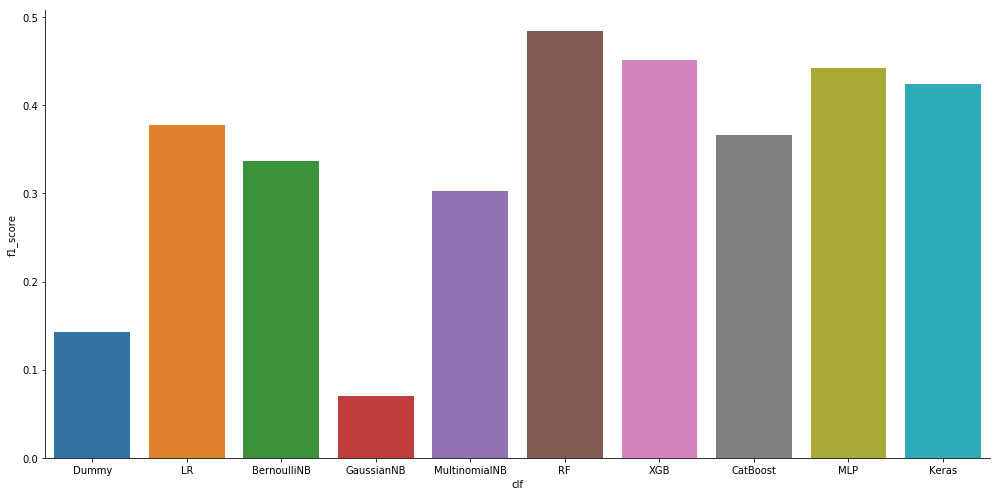

In [14]:
g =sns.catplot(data=df, y='f1_score', x='clf', kind="bar", height=7, aspect=2);

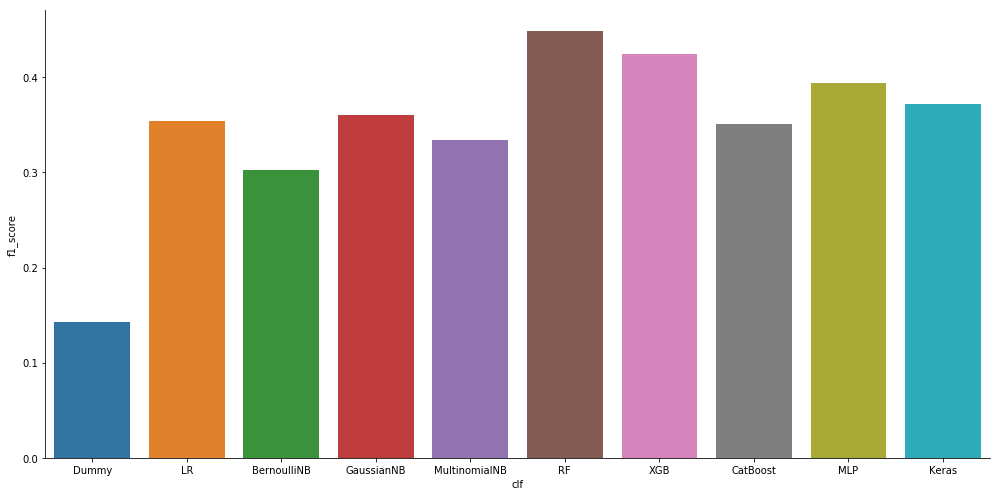

In [15]:
g =sns.catplot(data=df_pca, y='f1_score', x='clf', kind="bar", height=7, aspect=2);

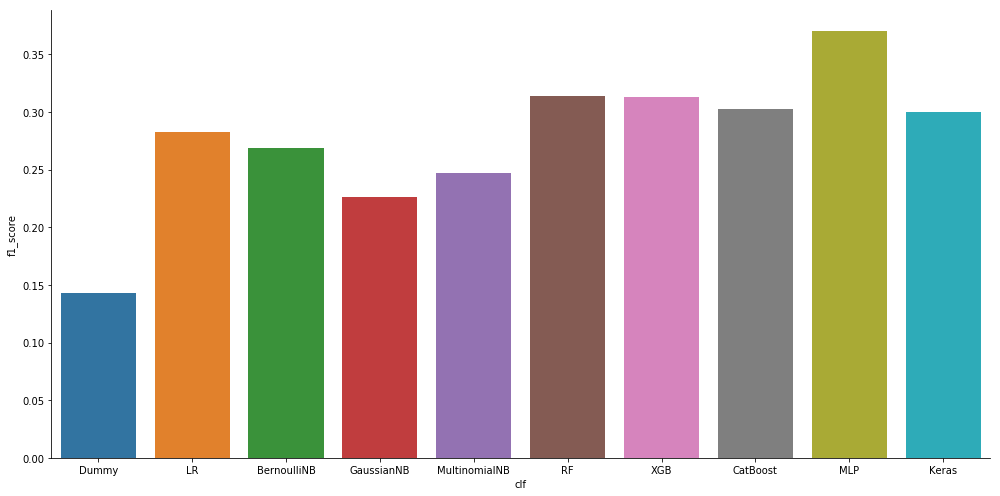

In [16]:
g =sns.catplot(data=df_chi2, y='f1_score', x='clf', kind="bar", height=7, aspect=2);

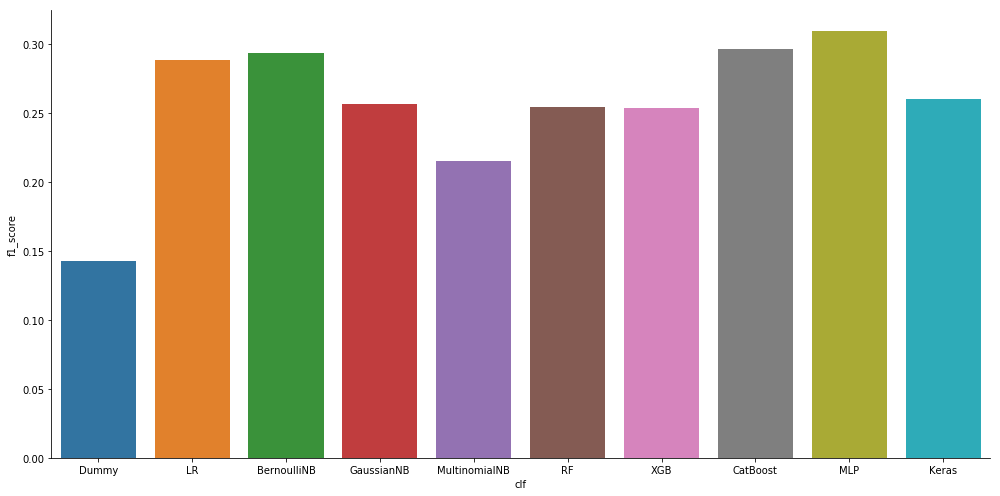

In [17]:
g =sns.catplot(data=df_chi22, y='f1_score', x='clf', kind="bar", height=7, aspect=2);

In [18]:
df.set_index('clf', inplace=True)
df_pca.set_index('clf', inplace=True)
df_chi2.set_index('clf', inplace=True)

Random Forest

In [19]:
print(df.loc['RF']['report'])

                          precision    recall  f1-score   support

                       -       0.59      0.91      0.71      3059
                 DAMAGED       0.35      0.23      0.28      1159
               DIFFERENT       0.43      0.14      0.21       836
                    FAKE       0.33      0.04      0.07        24
            NOT_RECEIVED       0.52      0.57      0.54      2831
SELLER_CANCEL_POSTERIORI       0.50      0.51      0.51      2698
               UNDEFINED       0.44      0.17      0.25       790
              WITHDRAWAL       0.40      0.24      0.30      1365

             avg / total       0.49      0.52      0.48     12762



In [20]:
print(df_pca.loc['RF']['report'])

                          precision    recall  f1-score   support

                       -       0.57      0.89      0.70      3059
                 DAMAGED       0.30      0.18      0.23      1159
               DIFFERENT       0.41      0.11      0.17       836
                    FAKE       0.00      0.00      0.00        24
            NOT_RECEIVED       0.47      0.54      0.50      2831
SELLER_CANCEL_POSTERIORI       0.47      0.47      0.47      2698
               UNDEFINED       0.40      0.14      0.21       790
              WITHDRAWAL       0.35      0.19      0.25      1365

             avg / total       0.46      0.49      0.45     12762



In [21]:
print(df_chi2.loc['RF']['report'])

                          precision    recall  f1-score   support

                       -       0.54      0.88      0.67      3059
                 DAMAGED       0.23      0.13      0.16      1159
               DIFFERENT       0.13      0.38      0.20       836
                    FAKE       0.01      0.42      0.01        24
            NOT_RECEIVED       0.45      0.08      0.14      2831
SELLER_CANCEL_POSTERIORI       0.54      0.19      0.28      2698
               UNDEFINED       0.21      0.18      0.19       790
              WITHDRAWAL       0.25      0.20      0.22      1365

             avg / total       0.42      0.34      0.31     12762

